In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from deep_hedging import (
    Underlyings,
    Ticker,
    ConstantRateCurve,
    EuropeanCall,
)
from deep_hedging.hedger import Hedger
from deep_hedging.monte_carlo import GBMSimulator

RANDOM_SEED = 12

In [3]:
N_PATHS = 100_000
N_STOCKS = 1
TILL_MATURITY = 3.0
N_DAYS = 365 * TILL_MATURITY
RF_RATE = 0.03
STRIKE_LEVEL = 1.0
VOL = 0.2

In [4]:
np.random.seed(RANDOM_SEED)

start = dt.datetime(2019, 1, 1)
end = start + dt.timedelta(days=N_DAYS)

underlyings = Underlyings(
    tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
    start=start,
    end=end,
    dividends=np.array([0.0] * N_STOCKS),
    means=np.array([RF_RATE] * N_STOCKS),
    var_covar=np.array([VOL**2] * N_STOCKS),
)
underlyings.data

In [5]:
curve = ConstantRateCurve(constant_rate=RF_RATE)

In [6]:
european_call = EuropeanCall(
    underlyings=underlyings,
    yield_curve=curve,
    strike_level=STRIKE_LEVEL,
    start_date=start,
    end_date=end,
)

In [7]:
pricer = GBMSimulator(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)

In [8]:
paths = pricer.get_paths(
    spot=[1.0],
    time_till_maturity=TILL_MATURITY,
    risk_free_rate_fn=curve.get_instant_fwd_rate,
    dividends_fn=lambda t: 0.0,
    var_covar_fn=lambda t: np.array([VOL**2] * len(t)),
    n_paths=N_PATHS,
).squeeze(2)
paths.shape

(100000, 1095)

In [9]:
hedger = Hedger(european_call, look_ahead=True)

In [10]:
pnl_hedge, pnl_opt = hedger.simulate(
    bids=paths,
    asks=paths,
    rates_lend=curve(european_call.days_till_maturity) / 365,
    rates_borrow=curve(european_call.days_till_maturity) / 365,
)
pnl_hedge.mean(), pnl_opt.mean()

(0.0003530956628952578, 0.19621281847488928)

In [11]:
pnl_hedge

array([-0.19735192, -0.19288501, -0.19532841, ..., -0.06257501,
        0.61130308, -0.1926803 ])

In [12]:
RF_RATE * european_call.time_till_maturity

0.09

In [13]:
(pnl_opt - pnl_hedge).mean() * np.exp(-RF_RATE * european_call.time_till_maturity)

0.17900230861645994

In [14]:
# pnl_hedge_fix, _, _ = hedger.simulate(
#     bids=paths,
#     asks=paths,
#     rates_lend=curve(european_call.days_till_maturity) / 365,
#     rates_borrow=curve(european_call.days_till_maturity) / 365,
#     weights=np.ones(paths.shape) * european_call.delta()
# )

In [15]:
(np.ones(paths.shape) * european_call.delta()).shape

(100000, 1095)

In [16]:
paths.shape

(100000, 1095)

In [17]:
pnl_opt.std(), pnl_hedge.std(), (pnl_hedge - pnl_opt).std()

(0.30269287340909307, 0.3022660661106842, 0.0037361828226865758)

In [18]:
european_call.price()

array([[0.17899527]])

In [19]:
pnl_opt.mean() * np.exp(-RF_RATE * european_call.time_till_maturity)

0.1793250137541639

In [20]:
np.corrcoef(pnl_hedge, pnl_opt)

array([[1.        , 0.99992471],
       [0.99992471, 1.        ]])

In [21]:
(
    pnl_opt - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).mean()

0.0003607928346367135

In [22]:
(
    pnl_opt - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).std()

0.30269287340909307

In [23]:
(
    pnl_opt
    - pnl_hedge
    - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).std()

0.0037361828226865758

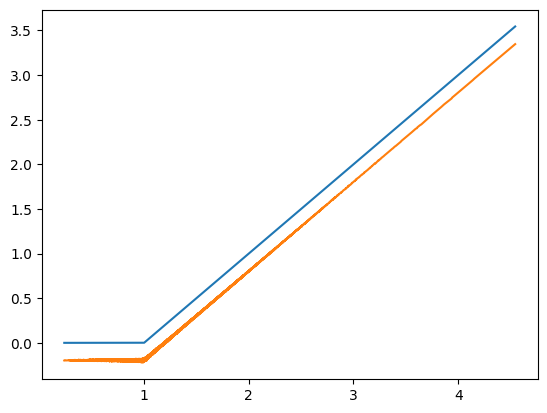

In [24]:
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

In [25]:
(pnl_hedge - RF_RATE * european_call.time_till_maturity).mean()

-0.08964690433710473

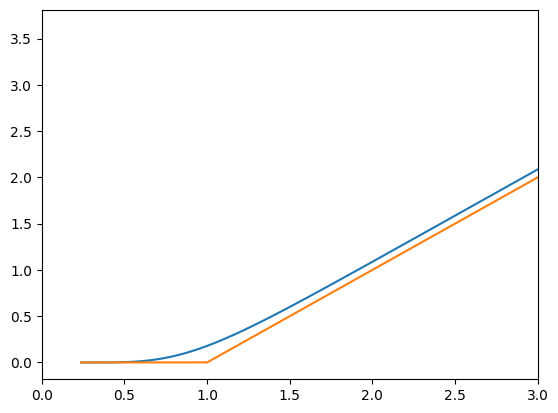

In [26]:
value_opt = european_call.price(spot=paths[:, -1])

plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.xlim([0, 3])
plt.show()

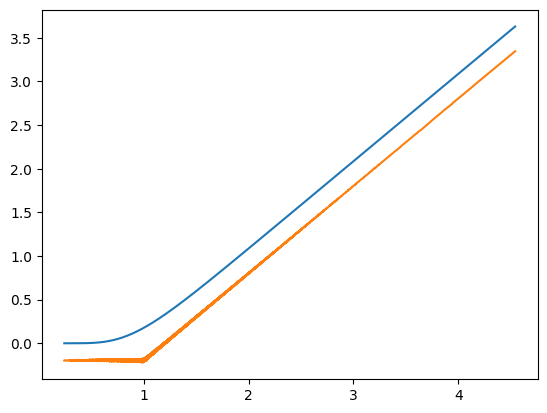

In [27]:
plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

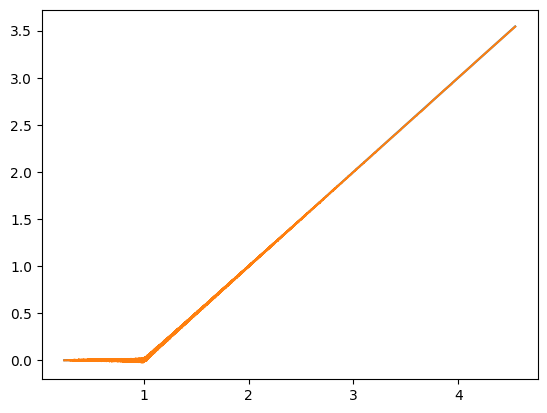

In [28]:
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(
    np.sort(paths[:, -1]),
    pnl_hedge[np.argsort(paths[:, -1])]
    + european_call.price().T.squeeze(1)
    * np.exp(RF_RATE * european_call.time_till_maturity),
)
plt.show()

In [29]:
portfolio = (
    pnl_hedge
    + european_call.price().T.squeeze(1)
    * np.exp(RF_RATE * european_call.time_till_maturity)
    - pnl_opt
)
portfolio.mean(), portfolio.std()

(-7.69717174144678e-06, 0.0037361828226865758)

In [30]:
european_call.delta()

array([[0.66749723]])

In [31]:
0.6 * RF_RATE * european_call.time_till_maturity

0.05399999999999999